# Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from src.calibration import *
from src.transform import *
from src.threshold import *
from src.lines import *
from src.plotting import *

In [2]:
calibration = Calibration('camera_cal/', (9, 6))
transform = Transform()
threshold = Threshold()
lines = Lines()

# Functions

# Load Image

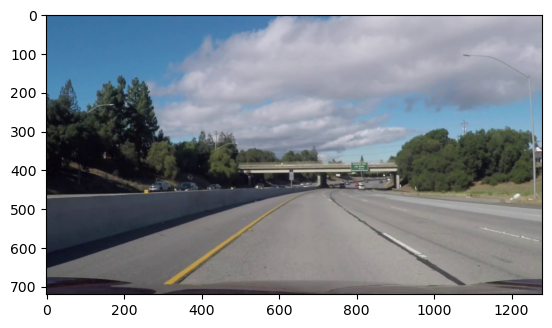

In [342]:
orig_img = cv2.imread('output_media/debug/problem_frames/0_frame.png')
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
plt.imshow(orig_img)

# Remove Image Distortion

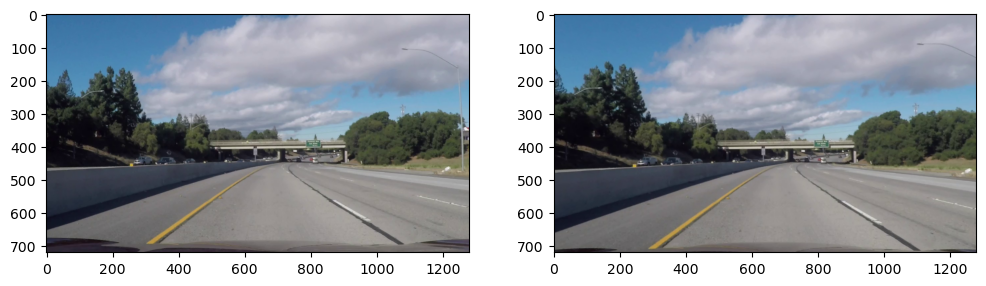

In [343]:
cal_img = calibration.undistort(orig_img)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(orig_img)
axs[1].imshow(cal_img)
fig.set_figwidth(12)

plt.show()

# Bird's Eye View

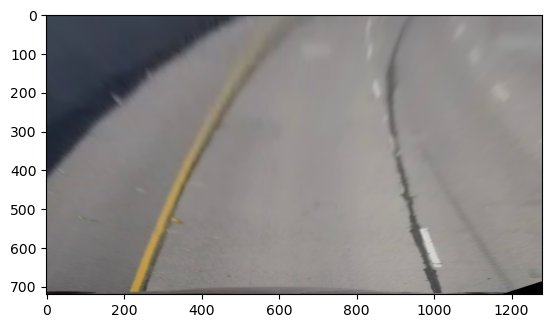

In [344]:
bev_img = transform.orig_to_bev(cal_img)
plt.imshow(bev_img)

# Thresholding

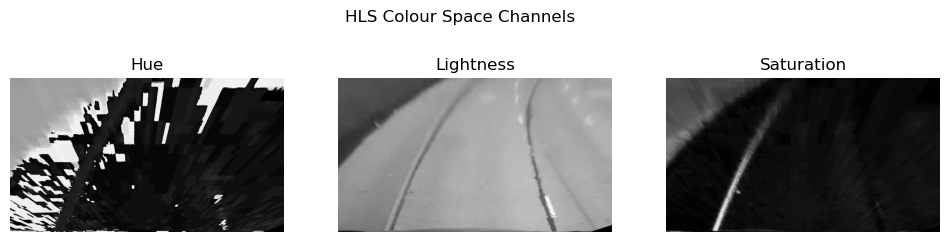

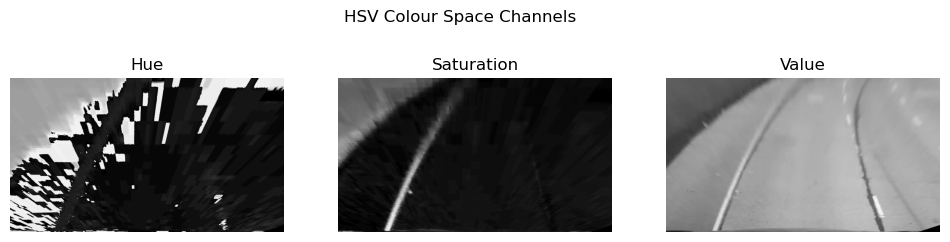

In [345]:
hls = cv2.cvtColor(bev_img, cv2.COLOR_RGB2HLS)
hsv = cv2.cvtColor(bev_img, cv2.COLOR_RGB2HSV)

hls_dict = {
    'Hue' : hls[:,:,0],
    'Lightness' : hls[:,:,1],
    'Saturation' : hls[:,:,2]
}

hsv_dict = {
    'Hue' : hsv[:,:,0],
    'Saturation' : hsv[:,:,1],
    'Value' : hsv[:,:,2]
}

plot_channels(hls_dict, title='HLS Colour Space Channels')
plot_channels(hsv_dict, title='HSV Colour Space Channels')

## Yellow

In [346]:
# yellow_lower_range = np.array([0, 100, 100])
# yellow_upper_range = np.array([50, 255, 255])

# yellow = cv2.inRange(hsv, yellow_lower_range, yellow_upper_range)

# plt.imshow(yellow, cmap='gray')

## White

In [347]:
# gray = cv2.cvtColor(bev_img, cv2.COLOR_RGB2GRAY)
# white_lower_range = np.array([200])
# white_upper_range = np.array([255])

# white = cv2.inRange(gray, white_lower_range, white_upper_range)
# plt.imshow(white, cmap='gray')

## Value

In [348]:
# v_channel = hsv_dict['Value']
# v_channel_lower_range = np.array([175])
# v_channel_upper_range = np.array([255])

# value = cv2.inRange(v_channel, v_channel_lower_range, v_channel_upper_range)
# plt.imshow(value, cmap='gray')

## Relative Thresholding

In [349]:
# gray_thresh = 125

# if np.mean(gray) <= gray_thresh:
#     v_channel = hsv_dict['Value']
#     v_channel_lower_range = np.array([180])
#     v_channel_upper_range = np.array([255])
#     relative = cv2.inRange(v_channel, v_channel_lower_range, v_channel_upper_range)
# else:
#     s_channel_lower = np.array([200])
#     s_channel_upper = np.array([255])
#     relative = cv2.inRange(hls_dict['Saturation'], s_channel_lower, s_channel_upper)

# plt.imshow(relative, cmap='gray')

## Adaptive Thresholding

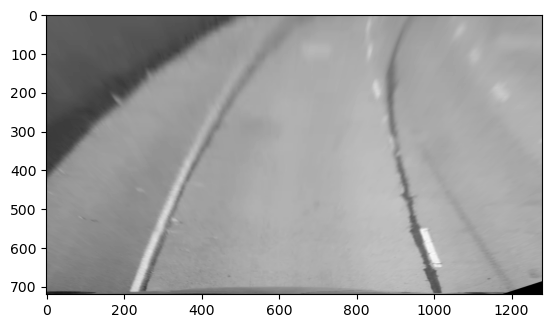

In [350]:
plt.imshow(hsv_dict['Value'],cmap='gray')

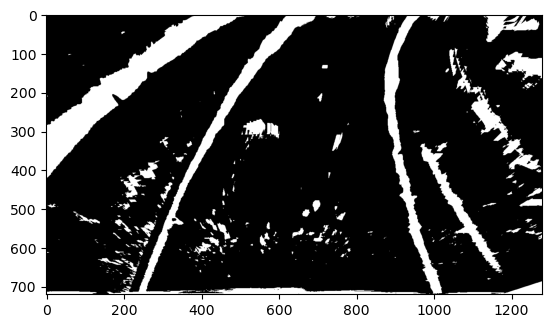

In [351]:
adpt_thresh_1 = cv2.adaptiveThreshold(hls_dict['Lightness'], 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 255, 3)
plt.imshow(adpt_thresh_1, cmap='gray')

## Combined Threshold

In [352]:
# thresh_img = yellow | white | relative
# plt.imshow(thresh_img, cmap='gray')

## HLS Thresholding

In [353]:
# np.mean(hls_dict['Lightness'])

In [354]:
# plt.imshow(hls_dict['Lightness'], cmap='gray')

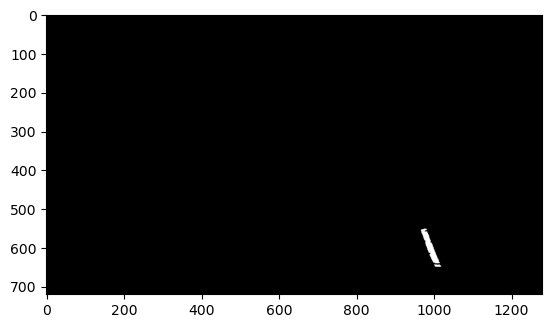

In [378]:
lightness_lower = np.array([195])
lightness_upper = np.array([255])

lightness = cv2.inRange(hls[:, :, 1], lightness_lower, lightness_upper)
plt.imshow(lightness, cmap='gray')

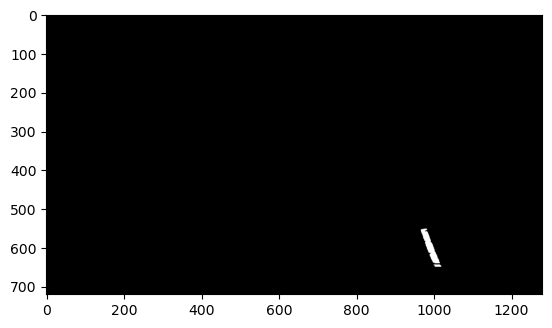

In [356]:
if np.mean(hls[:, 400:820, 1]) >= 120:
    white_lower = np.array([int(0 / 2), int(0.75 * 255), int(0.00 * 255)])
else:
    white_lower = np.array([int(0 / 2), int(0.67 * 255), int(0.00 * 255)])

# white_lower = np.array([int(0 / 2), int(0.67 * 255), int(0.00 * 255)])
white_upper = np.array([int(360 / 2), int(1.00 * 255), int(1.00 * 255)])
relative = cv2.inRange(hls, white_lower, white_upper)
plt.imshow(relative, cmap='gray')

In [357]:
np.mean(hls[:, 400:820, 1])

142.66011904761905

In [358]:
# if np.mean(hls[:, 400:820, 1]) <= 110:
#     relative = cv2.inRange(hls[:, :, 1], np.array([185]), np.array([255]))
# else:
#     relative = cv2.inRange(hls[:, :, 1], np.array([200]), np.array([255]))
# plt.imshow(relative,cmap='gray')

In [359]:
np.mean(hsv[:,:,2])

136.31730577256945

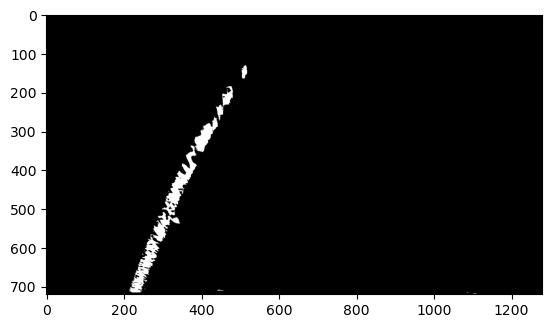

In [384]:
if np.mean(hsv[:,:,2]) <= 80:
    yellow_lower = np.array([int(40 / 2), int(0.05 * 255), int(0.00 * 255)])
else:
    yellow_lower = np.array([int(40 / 2), int(0.20 * 255), int(0.00 * 255)])
yellow_upper = np.array([int(50 / 2), int(1.00 * 255), int(1.00* 255)])
yellow = cv2.inRange(hsv, yellow_lower, yellow_upper)
plt.imshow(yellow, cmap='gray')

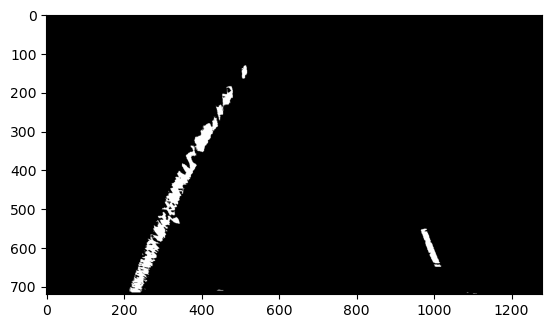

In [361]:
thresh_img = yellow | lightness
plt.imshow(thresh_img, cmap='gray')

In [362]:
# mask = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel=np.ones((8,8),dtype=np.uint8))
# thresh_img = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=np.ones((20,20),dtype=np.uint8))
# plt.imshow(thresh_img, cmap='gray')

## HSV and HLS Thresholding

In [363]:
# np.mean(hsv_dict['Value'])

In [364]:
# white_lower = np.array([int(0 / 2), int(0.00 * 255), int(0.90 * 255)])
# white_upper = np.array([int(360 / 2), int(1.00 * 255), int(1.00* 255)])
# white = cv2.inRange(hsv, white_lower, white_upper)
# plt.imshow(white, cmap='gray')

In [365]:
# yellow_lower = np.array([int(40 / 2), int(0.20 * 255), int(0.20 * 255)])
# yellow_upper = np.array([int(60 / 2), int(1.00* 255), int(1.00 * 255)])
# yellow = cv2.inRange(hls, yellow_lower, yellow_upper)
# plt.imshow(yellow, cmap='gray')

In [366]:
# thresh_img = yellow | white
# plt.imshow(thresh_img, cmap='gray')

## Inspecting Threshold for Multiple Images

In [367]:
# # Get file names
# fnames = glob("{}/*".format('test_images/'))

# # Create dict to store images
# dict = dict.fromkeys(['original', 'bev', 'yellow', 'white', 'value', 'combined'])

# # Define subplot parameters
# nrows = len(fnames)
# ncols = len(dict)

# # Create figure
# fig, axs = plt.subplots(nrows, ncols, figsize=(12,12))

# # Set title of each column
# for ax, col in zip(axs[0], dict.keys()):
#     ax.set_title(col)

# # Iterate through images and generate threshold images
# for row, file in enumerate(fnames):
#     # Read in image
#     img = cv2.imread(file)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     dict['original'] = img

#     img = calibration.undistort(img)
#     img = transform.orig_to_bev(img)
#     dict['bev'] = img

#     # Get colour spaces
#     hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#     # Apply colour-specific thresholding
#     dict['yellow'] = cv2.inRange(hsv, yellow_lower_range, yellow_upper_range)
#     dict['white'] = cv2.inRange(gray, white_lower_range, white_upper_range)
#     dict['value'] = cv2.inRange(v_channel, v_channel_lower_range, v_channel_upper_range)

#     # Combine threshold channels
#     dict['combined'] = dict['yellow'] | dict['white'] | dict['value']

#     for col, (title, img) in enumerate(dict.items()):
#         if title in ['original', 'bev']:
#             axs[row, col].imshow(img)
#         else:
#             axs[row, col].imshow(img, cmap='gray')
#         axs[row, col].axis(False)

# fig.tight_layout()
# plt.show()

# Find Lines

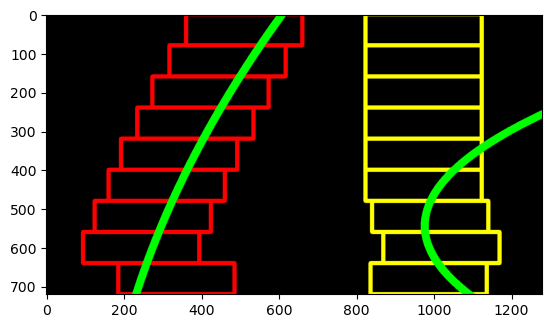

In [379]:
lines_img = lines.sliding_window(thresh_img, draw_boxes=True)
plt.imshow(lines_img)

# Transform to Front View

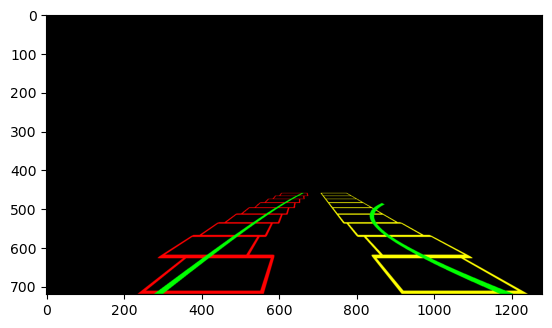

In [369]:
trans_lines_img = transform.bev_to_orig(lines_img)
plt.imshow(trans_lines_img)

# Combine Original Image and Lines

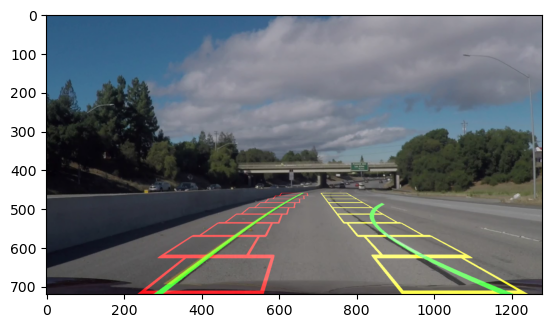

In [370]:
output_img = cv2.addWeighted(orig_img, 0.8, trans_lines_img, 1.0, 0.0)
plt.imshow(output_img)

In [371]:
# lightness_lower = np.array([200])
# lightness_upper = np.array([255])
# white_lower = np.array([int(0 / 2), int(0.67 * 255), int(0.00 * 255)])
# white_upper = np.array([int(360 / 2), int(1.00 * 255), int(1.00 * 255)])
# yellow_lower = np.array([int(40 / 2), int(0.20 * 255), int(0.20 * 255)])
# yellow_upper = np.array([int(50 / 2), int(1.00* 255), int(1.00 * 255)])

# debug_folder = 'output_media/debug/problem_frames/'
# fnames = glob("{}/*".format(debug_folder))

# nfigs = 4
# nrows = 3 * nfigs
# ncols = 4
# img_size = (720, 1280)

# # fig, axs = plt.subplots(nrows, ncols)
# # axs = axs.flatten()
# px = 1/plt.rcParams['figure.dpi']  # pixel in inches
# fig = plt.figure(figsize=(ncols*img_size[1]*px, nrows*img_size[0]*px))
# fig = plt.figure()
# x = 1

# for file in fnames[:4]:
#     orig_img = cv2.imread(file)
#     orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
#     cal_img = calibration.undistort(orig_img)
#     bev_img = transform.orig_to_bev(cal_img)
#     hls = cv2.cvtColor(bev_img, cv2.COLOR_RGB2HLS)
#     hsv = cv2.cvtColor(bev_img, cv2.COLOR_RGB2HSV)
#     h, l, s = cv2.split(hls)
#     h, s, v = cv2.split(hsv)
#     lightness = cv2.inRange(l, lightness_lower, lightness_upper)
#     white = cv2.inRange(hls, white_lower, white_upper)
#     yellow = cv2.inRange(hls, yellow_lower, yellow_upper)
#     combined = white | yellow

#     img_list = [
#         orig_img, h, l , s,
#         bev_img, h, s, v,
#         lightness, white, yellow, combined
#     ]

#     for img in img_list:
#         ax = fig.add_subplot(nrows, ncols, x)
#         ax.imshow(img, cmap='gray')
#         ax.axis('off')
#         ax.set_aspect('equal')
#         x += 1


# # fig.tight_layout()
# fig.savefig('book_images/problem_frames.png')
# fig.subplots_adjust(wspace = 0)
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.show()

In [372]:
# plt.rcParams['figure.dpi'] = 100
# plt.rcParams['figure.dpi']

In [373]:
# fig = plt.figure()
# x = 1
# for _ in range(12):
#     ax = fig.add_subplot(4, 4, x)
#     ax.imshow(orig_img)
#     ax.axis('off')
#     x+=1

# for _ in range(4):
#     ax = fig.add_subplot(4, 4, x)
#     ax.imshow(thresh_img)
#     ax.axis('off')
#     x+=1

# plt.show()